# CODE SETUP

In [389]:
# suspicion - suspicious or innocent
# record - theft, robbery, scam, murder, homicide etc...

In [390]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [391]:
# Node
class Person:
    
    def __init__(self, name, suspicion, record):
        self.parent = None
        self.neighbors = [] # adjacency list
        self.name = name 
        self.suspicion = suspicion
        self.record = record
    
    def get_neighbors(self):
        return self.neighbors
    
    def get_name(self):
        return self.name
    
    def get_suspicion(self):
        return self.suspicion
    
    def get_record(self): 
        return self.record
    
    def add_neighbor(self, person):
        self.neighbors.append(person)
    
    def clear_neighbors(self):
        self.neighbors.clear()
    
    def __str__(self):
        return f"{self.name}: {self.neighbors}"
    
    def __repr__(self):
        return self.name

In [392]:
class Graph:
    
    def __init__(self, graph_repr=None, directional=False):
        if graph_repr is None:
            graph_repr = []
        self.graph_repr = graph_repr
        self.graph_graphical = []
        self.directional = directional
        
    def show_graph(self, graphical=False):
        if not graphical:
            if self.graph_repr:
                for node in self.graph_repr:
                    print(node)
            else:
                print("Nothing in graph!")
        else:
            if self.graph_repr:
                graphical = nx.Graph()
                graphical.add_edges_from(self.graph_graphical)
                nx.draw_networkx(graphical)
                plt.show()
            else:
                print("Nothing in graph!")
    
    def get_nodes(self):
        return self.graph_repr
            
    def add_node(self, node):
        if node not in self.graph_repr:
            self.graph_repr.append(node)
        else:
            print("Node already present in graph!")
            
    def add_edge(self, node1, node2):
        if node1 in self.graph_repr and node2 in self.graph_repr:
            node1_repr = node1.name.split("person")[-1]
            node2_repr = node2.name.split("person")[-1]
            if self.directional is True:
                if node2 not in node1.get_neighbors():
                    node1.add_neighbor(node2)
                    self.graph_graphical.append([node1_repr, node2_repr])
                else:
                    print("Second node already present in node!")
            else:
                if node1 not in node2.get_neighbors() and \
                   node2 not in node1.get_neighbors():
                    node1.add_neighbor(node2)
                    node2.add_neighbor(node1)
                    self.graph_graphical.append([node1_repr, node2_repr]) 
                else:
                    print("Nodes already connected by an edge!")    
        else:
            print("A node is not present in graph!")
    
    def add_edges(self, node, edge_list):
        for neighbor in edge_list:
            self.add_edge(node, neighbor)
            
    def clear_edges(self):
        for item in self.graph_repr:
            item.clear_neighbors()
            
    def clear_graph(self):
        self.graph_repr.clear()

In [393]:
class CriminalGroupDetection:

    def __init__(self, graph):
        self.graph = graph
        self.targets = {}
        self._get_poi()
    
    # get persons of interest
    def _get_poi(self): 
        for person in self.graph.get_nodes():
            if person.get_suspicion() == "suspicious":
                if person.get_record() not in self.targets:
                    self.targets[person.get_record()] = []
                    self.targets[person.get_record()].append(person)
                else:
                    self.targets[person.get_record()].append(person)

    # check if visited node has the same record as initial node
    def _test_connection(self, neighbor, connections, record):
        if neighbor.get_suspicion() == "suspicious" \
           and neighbor.get_record() == record:
            connection = [neighbor]
            parent = neighbor.parent
            while parent is not None:
                connection.append(parent)
                parent = parent.parent
            connections.append(connection[::-1])
        
    def _provide_details(self, edge_list, mediators, independents):
        print(" ========================================")
        print("          POSSIBLE CRIMINAL GROUPS")
        print(" ========================================")
        graphical = nx.Graph()
        graphical.add_edges_from(edge_list)
        nx.draw_networkx(graphical)
        plt.show()
        print(" ========================================")
        print("             SUSPICIOUS TARGETS")
        print(" ========================================")
        for record, targets in self.targets.items():
            print(f" {record}: {targets}")
        print(" ========================================")
        print("            MEDIATING ENTITIES")
        print(" ========================================")
        for med in mediators:
            print(f" Name: {med.get_name()}, {med.get_suspicion()}")
        print(" ========================================")
        print("              INDEPENDENT CASES")
        print(" ========================================")
        for ind in independents:
            print(f" Name: {ind.get_name()}, Record: {ind.get_record()}")
    
    # gets the shortest path to all nodes that has the same record as initial
    # node with a specified depth level using bfs
    def determine_connection(self, node, target_level=2):
        suspicion = node.get_record()          # target level is used to specify
        visited  = [node]                      # the amount of levels the BFS
        queue = [node]                         # would check to find connections
        connections = []                       # depending on importance.
        last_node = node.get_neighbors()[-1]
        current_level = 1
        while queue:
            current_node = queue.pop(0)
            for neighbor in current_node.get_neighbors():
                if current_level != target_level:
                    if neighbor != last_node:
                        if neighbor not in visited:
                            neighbor.parent = current_node
                            self._test_connection(neighbor, connections, 
                                                  suspicion)
                            visited.append(neighbor)
                            queue.append(neighbor)
                    else:
                        current_level += 1
                        last_node = neighbor.get_neighbors()[-1]
                        if neighbor not in visited:
                            neighbor.parent = current_node
                            self._test_connection(neighbor, connections, 
                                                  suspicion)
                            visited.append(neighbor)
                            queue.append(neighbor)
                else:
                    if neighbor not in visited:
                        neighbor.parent = current_node
                        self._test_connection(neighbor, connections, 
                                              suspicion)
                        visited.append(neighbor)
        for node in visited:
            node.parent = None
        return connections
    
    # establish full connection to all similar record node
    def determine_criminal_groups(self, target_level=2):
        groups = dict()
        independents = []
        for key in self.targets:
            for person in self.targets[key]:
                connection = self.determine_connection(person, target_level)
                if connection != []:
                    if key not in groups:
                        groups[key] = connection
                    else:
                        for con in connection:
                            if con[::-1] not in groups[key]:
                                groups[key].append(con)
                else:
                    independents.append(person)
        return groups, independents
    
    # show all possible crime groups
    def show_criminal_groups(self, target_level=2):
        groups, independents = self.determine_criminal_groups(target_level)
        edge_list = []
        mediators = []
        for record in groups:
            for edges in groups[record]:
                for index, node in enumerate(edges):
                    if index < (len(edges) - 1):
                        if node.get_suspicion() == "innocent" or \
                           node.get_record() != record:
                            mediators.append(node)
                        edge_list.append([int(node.name.split("person")[-1]),
                            int(edges[index + 1].name.split("person")[-1])])
        for ind in independents:
            node = int(ind.name.split("person")[-1])
            edge_list.append([node, node])
        self._provide_details(edge_list, list(set(mediators)), independents)

    def show_targets(self):
        return self.targets

# GRAPH

In [394]:
graph = Graph()

In [395]:
person1 = Person("person1", "innocent", None)
person2 = Person("person2", "innocent", None)
person3 = Person("person3", "suspicious", "Arsony")
person4 = Person("person4", "innocent", None)
person5 = Person("person5", "suspicious", "Arsony")
person6 = Person("person6", "suspicious",'Theft')
person8 = Person("person8", "innocent", None)
person9 = Person("person9", "innocent", None)
person10 = Person("person10", "suspicious",'Arsony')
person11 = Person("person11", "innocent", None)
person14 = Person("person14", "innocent", None)
person15 = Person("person15", "innocent", None)
person16 = Person("person16", "suspicious", 'Homicide')
person17 = Person("person17","suspicious", "Theft")
person18 = Person("person18", "suspicious", "Theft")
person20 = Person("person20", "innocent", None)
person21 = Person("person21", "innocent", None)
person23 = Person("person23", "innocent", None)
person24 = Person("person24", "innocent", None)
person25 = Person("person25", "suspicious", 'Theft')
person26 = Person("person26", "innocent", None)
person28 = Person("person28", "innocent", None)
person29 = Person("person29", "innocent", None)
person30 = Person("person30", "innocent", None)
person31 = Person("person31", "innocent", None)
person32 = Person("person32", "suspicious", "Arsony")
person34 = Person("person34", "innocent", None)
person35 = Person("person35", "innocent", None)
person36 = Person("person36", "innocent", None)
person37 = Person("person37", "innocent", None)
person38 = Person("person38", "innocent", None)
person39 = Person("person39", "innocent", None)
person40 = Person("person40", "innocent", None)
person41 = Person("person41", "innocent", None)
person42 = Person("person42", "innocent", None)
person44 = Person("person44", "suspicious",'Theft')
person45 = Person("person45", "innocent", None)
person46 = Person("person46", "innocent", None)
person47 = Person("person47", "innocent", None)
person48 = Person("person48", "innocent", None)
person49 = Person("person49", "innocent", None)
person51 = Person("person51", "suspicious", 'Drugs')

In [396]:
graph.add_node(person1)
graph.add_node(person2)
graph.add_node(person3)
graph.add_node(person4)
graph.add_node(person5)
graph.add_node(person6)
graph.add_node(person8)
graph.add_node(person9)
graph.add_node(person10)
graph.add_node(person11)
graph.add_node(person14)
graph.add_node(person15)
graph.add_node(person16)
graph.add_node(person17)
graph.add_node(person18)
graph.add_node(person20)
graph.add_node(person21)
graph.add_node(person23)
graph.add_node(person24)
graph.add_node(person25)
graph.add_node(person26)
graph.add_node(person28)
graph.add_node(person29)
graph.add_node(person30)
graph.add_node(person31)
graph.add_node(person32)
graph.add_node(person34)
graph.add_node(person35)
graph.add_node(person36)
graph.add_node(person37)
graph.add_node(person38)
graph.add_node(person39)
graph.add_node(person40)
graph.add_node(person41)
graph.add_node(person42)
graph.add_node(person44)
graph.add_node(person45)
graph.add_node(person46)
graph.add_node(person47)
graph.add_node(person48)
graph.add_node(person49)
graph.add_node(person51)

In [397]:
graph.add_edge(person16, person4)
graph.add_edge(person11, person4)
graph.add_edge(person4, person2)
graph.add_edge(person2, person39)
graph.add_edge(person2, person14)
graph.add_edge(person2, person47)
graph.add_edge(person2, person8)
graph.add_edge(person2, person1)
graph.add_edge(person8, person20)
graph.add_edge(person8, person1)
graph.add_edge(person1, person35)
graph.add_edge(person1, person41)
graph.add_edge(person1, person32)
graph.add_edge(person1, person48)
graph.add_edge(person1, person6)
graph.add_edge(person1, person25)
graph.add_edge(person1, person26)
graph.add_edge(person1, person30)
graph.add_edge(person32, person21)
graph.add_edge(person6, person31)
graph.add_edge(person6, person30)
graph.add_edge(person30, person15)
graph.add_edge(person30, person24)
graph.add_edge(person15, person28)
graph.add_edge(person28, person38)
graph.add_edge(person15, person9)
graph.add_edge(person9, person34)
graph.add_edge(person9, person40)
graph.add_edge(person34, person25)
graph.add_edge(person34, person49)
graph.add_edge(person34, person18)
graph.add_edge(person17, person42)
graph.add_edge(person17, person18)
graph.add_edge(person17, person1)
graph.add_edge(person18, person29)
graph.add_edge(person29, person44)
graph.add_edge(person31, person36)
graph.add_edge(person36, person46)
graph.add_edge(person46, person51)
graph.add_edge(person51, person3)
graph.add_edge(person3, person23)
graph.add_edge(person3, person21)
graph.add_edge(person21, person5)
graph.add_edge(person5, person10)
graph.add_edge(person10, person37)
graph.add_edge(person10, person45)

person1: [person2, person8, person35, person41, person32, person48, person6, person25, person26, person30, person17]
person2: [person4, person39, person14, person47, person8, person1]
person3: [person51, person23, person21]
person4: [person16, person11, person2]
person5: [person21, person10]
person6: [person1, person31, person30]
person8: [person2, person20, person1]
person9: [person15, person34, person40]
person10: [person5, person37, person45]
person11: [person4]
person14: [person2]
person15: [person30, person28, person9]
person16: [person4]
person17: [person42, person18, person1]
person18: [person34, person17, person29]
person20: [person8]
person21: [person32, person3, person5]
person23: [person3]
person24: [person30]
person25: [person1, person34]
person26: [person1]
person28: [person15, person38]
person29: [person18, person44]
person30: [person1, person6, person15, person24]
person31: [person6, person36]
person32: [person1, person21]
person34: [person9, person25, person49, person18

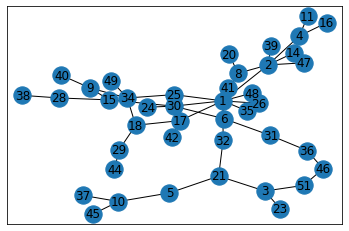

In [398]:
graph.show_graph()
graph.show_graph(graphical=True)

# EXECUTION

In [399]:
sample_community = CriminalGroupDetection(graph)

          POSSIBLE CRIMINAL GROUPS


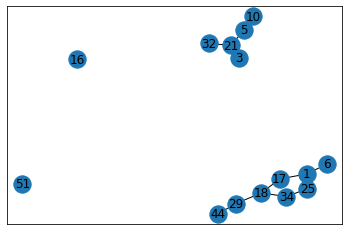

             SUSPICIOUS TARGETS
 Arsony: [person3, person5, person10, person32]
 Theft: [person6, person17, person18, person25, person44]
 Homicide: [person16]
 Drugs: [person51]
            MEDIATING ENTITIES
 Name: person1, innocent
 Name: person29, innocent
 Name: person34, innocent
 Name: person21, innocent
              INDEPENDENT CASES
 Name: person16, Record: Homicide
 Name: person51, Record: Drugs


In [400]:
sample_community.show_criminal_groups()